<h2>Solar Power Generation Forecasting</h2>

<h3>Importing Libraries And Dataset</h3>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

dts = pd.read_csv('solarpowergeneration.csv')
dts.head(10)


In [40]:
X = dts.iloc[:, :-1].values
y = dts.iloc[:, -1].values
print(X.shape, y.shape)
y = np.reshape(y, (-1,1))
y.shape

(4213, 20) (4213,)


(4213, 1)

X

In [5]:
y

array([[ 454.10095 ],
       [1411.9994  ],
       [2214.8493  ],
       ...,
       [ 158.36778 ],
       [ 126.95306 ],
       [  20.055031]])

<h3>Splitting Training and Test sets</h3>

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Shape: {} {} \nTest Shape: {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
     

Train Shape: (3159, 20) (3159, 1) 
Test Shape: (1054, 20) (1054, 1)


<h3>Feature Scaling</h3>

In [8]:
from sklearn.preprocessing import StandardScaler
# input scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# outcome scaling:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)    
y_test = sc_y.transform(y_test)

In [9]:
X_train

array([[-0.15688663, -0.65066193,  0.32458773, ..., -1.17016507,
         0.20906612,  0.23973116],
       [-0.96299273,  1.26236489, -0.09488224, ...,  0.21285162,
         1.10270022, -0.59126299],
       [-0.01104135, -0.22554486, -1.44007902, ..., -0.78166945,
        -1.98808451, -0.32872643],
       ...,
       [ 0.08053592, -0.39559169, -0.65899702, ..., -1.39867408,
        -1.07235309, -0.0910784 ],
       [ 0.34283131, -0.90573217,  0.59941288, ..., -0.46582577,
         0.41541699,  0.76311909],
       [-0.6893915 ,  0.62468928,  1.45281728, ...,  0.28508139,
         0.20437129, -0.90996355]])

In [10]:
X_test

array([[ 0.34735364, -1.37336095,  0.58494839, ..., -0.78124559,
        -0.35197112,  0.78338018],
       [-1.93190285,  1.68748196, -0.84703527, ...,  0.34119265,
         1.11388012, -0.66875224],
       [-0.95055631,  0.28459563,  0.97548939, ...,  0.32973403,
        -0.38653881, -1.09819031],
       ...,
       [ 0.69783455, -1.37336095,  1.09120525, ..., -0.47407508,
         0.36095606,  0.77638555],
       [-0.00991077, -1.6709429 ,  1.93014517, ..., -1.21521633,
         0.12748879,  0.27526625],
       [-0.58537781,  1.00729465, -1.0640025 , ...,  0.07094803,
         0.619908  , -0.66549089]])

In [11]:
y_train

array([[ 0.37304328],
       [-0.96068338],
       [ 0.56242648],
       ...,
       [ 1.74385844],
       [-0.58299753],
       [-0.14116491]])

<h3>Creating Neural Network</h3>

In [12]:
def create_spfnet(n_layers, n_activation, kernels):
  model = tf.keras.models.Sequential()
  for i, nodes in enumerate(n_layers):
    if i==0:
      model.add(Dense(nodes, kernel_initializer=kernels, activation=n_activation, input_dim=X_train.shape[1]))
      #model.add(Dropout(0.3))
    else:
      model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels))
      #model.add(Dropout(0.3))
  
  model.add(Dense(1))
  model.compile(loss='mse', 
                optimizer='adam',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model


In [15]:
spfnet = create_spfnet([32, 64], 'relu', 'normal')
spfnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 32)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,849 (11.13 KB)

 Trainable params: 2,849 (11.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(spfnet, to_file='spfnet_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [22]:
hist = spfnet.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test),epochs=150, verbose=2)

Epoch 1/150
99/99 - 3s - 30ms/step - loss: 0.5269 - root_mean_squared_error: 0.7258 - val_loss: 0.2607 - val_root_mean_squared_error: 0.5106
Epoch 2/150
99/99 - 0s - 2ms/step - loss: 0.2507 - root_mean_squared_error: 0.5007 - val_loss: 0.2487 - val_root_mean_squared_error: 0.4987
Epoch 3/150
99/99 - 0s - 2ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859 - val_loss: 0.2585 - val_root_mean_squared_error: 0.5085
Epoch 4/150
99/99 - 0s - 2ms/step - loss: 0.2352 - root_mean_squared_error: 0.4850 - val_loss: 0.2390 - val_root_mean_squared_error: 0.4889
Epoch 5/150
99/99 - 0s - 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760 - val_loss: 0.2359 - val_root_mean_squared_error: 0.4856
Epoch 6/150
99/99 - 0s - 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718 - val_loss: 0.2395 - val_root_mean_squared_error: 0.4894
Epoch 7/150
99/99 - 0s - 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711 - val_loss: 0.2392 - val_root_mean_squared_error: 0.4891
Epoch 8/150
99/99 -

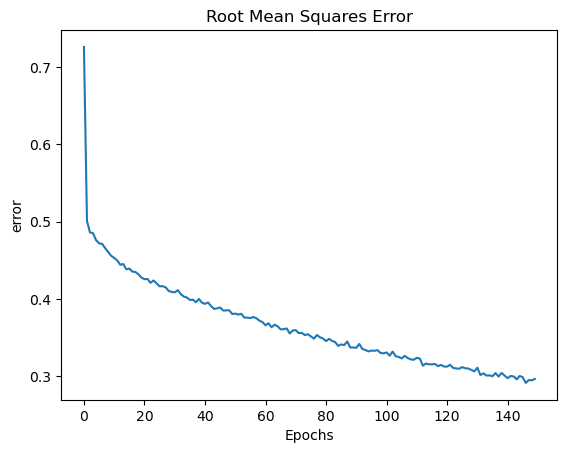

In [26]:
plt.plot(hist.history['root_mean_squared_error'])
#plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Root Mean Squares Error')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.show()

In [27]:
spfnet.evaluate(X_train, y_train)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0812 - root_mean_squared_error: 0.2849


[0.0803697481751442, 0.28349557518959045]

In [28]:
from sklearn.metrics import mean_squared_error

y_pred = spfnet.predict(X_test) # get model predictions (scaled inputs here)
y_pred_orig = sc_y.inverse_transform(y_pred) # unscale the predictions
y_test_orig = sc_y.inverse_transform(y_test) # unscale the true test outcomes

RMSE_orig = mean_squared_error(y_pred_orig, y_test_orig, squared=False)
RMSE_orig

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.487895026930946

In [29]:
train_pred = spfnet.predict(X_train) # get model predictions (scaled inputs here)
train_pred_orig = sc_y.inverse_transform(train_pred) # unscale the predictions
y_train_orig = sc_y.inverse_transform(y_train) # unscale the true train outcomes

mean_squared_error(train_pred_orig, y_train_orig, squared=False)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.2834955381123492

In [30]:
from sklearn.metrics import r2_score
r2_score(y_pred_orig, y_test_orig)

0.7609982468704973

In [25]:
r2_score(train_pred_orig, y_train_orig)

0.9135842004750072

In [31]:
np.concatenate((train_pred_orig, y_train_orig), 1)

array([[ 0.33431205,  0.37304328],
       [-0.62815893, -0.96068338],
       [ 0.65600359,  0.56242648],
       ...,
       [ 1.15193141,  1.74385844],
       [-0.42753866, -0.58299753],
       [ 0.2048959 , -0.14116491]])

In [32]:
np.concatenate((y_pred_orig, y_test_orig), 1)

array([[ 1.80789697,  1.47048101],
       [-0.65181327, -0.70178525],
       [ 0.86792493,  0.94248348],
       ...,
       [-0.33434001, -0.65547913],
       [ 1.38349915,  1.46509524],
       [-0.56633055, -0.6967306 ]])

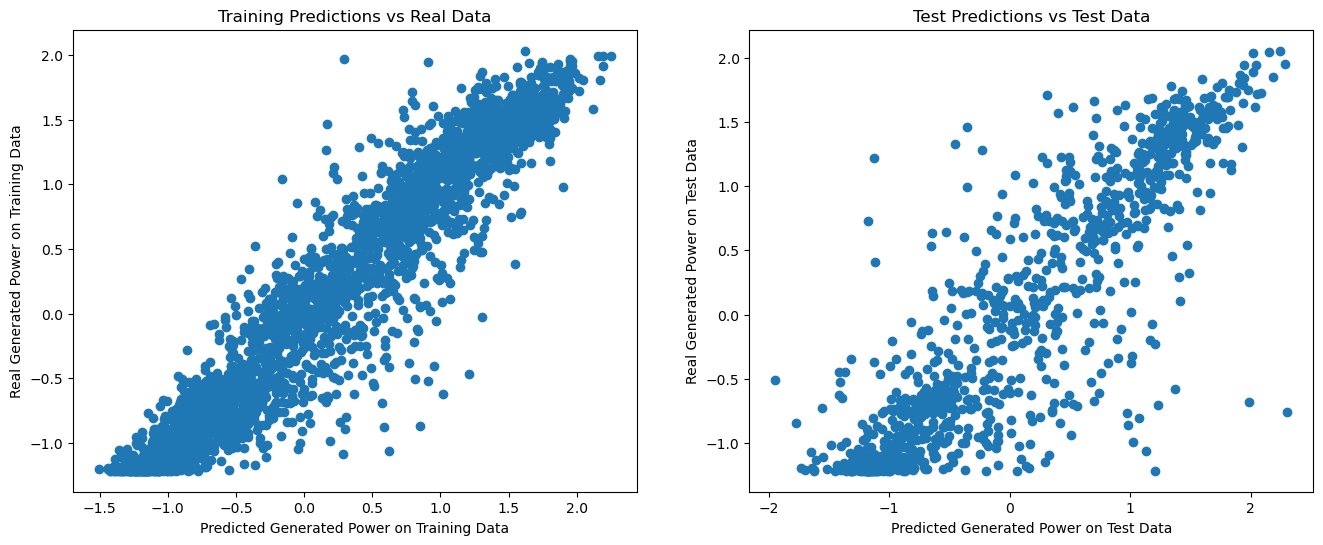

In [34]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,2)
plt.scatter(y_pred_orig, y_test_orig)
plt.xlabel('Predicted Generated Power on Test Data')
plt.ylabel('Real Generated Power on Test Data')
plt.title('Test Predictions vs Test Data')
#plt.scatter(y_test_orig, sc_X.inverse_transform(X_test)[:,2], color='green')
plt.subplot(1,2,1)
plt.scatter(train_pred_orig, y_train_orig)
plt.xlabel('Predicted Generated Power on Training Data')
plt.ylabel('Real Generated Power on Training Data')
plt.title('Training Predictions vs Real Data')
plt.show()
     

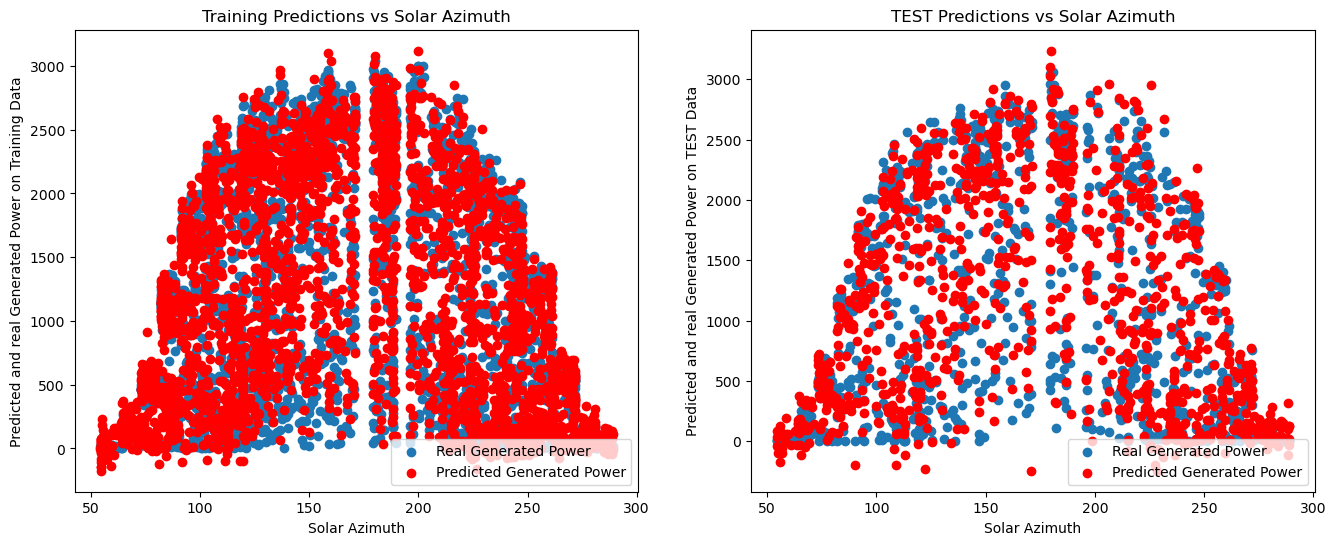

In [29]:
x_axis = sc_X.inverse_transform(X_train)[:,-1]
x2_axis = sc_X.inverse_transform(X_test)[:,-1]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x_axis, y_train_orig, label='Real Generated Power')
plt.scatter(x_axis, train_pred_orig, c='red', label='Predicted Generated Power')
plt.ylabel('Predicted and real Generated Power on Training Data')
plt.xlabel('Solar Azimuth')
plt.title('Training Predictions vs Solar Azimuth')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.scatter(x2_axis, y_test_orig, label='Real Generated Power')
plt.scatter(x2_axis, y_pred_orig, c='red', label='Predicted Generated Power')
plt.ylabel('Predicted and real Generated Power on TEST Data')
plt.xlabel('Solar Azimuth')
plt.title('TEST Predictions vs Solar Azimuth')
plt.legend(loc='lower right')
plt.show()

In [36]:
results = np.concatenate((y_test_orig, y_pred_orig), 1)
results = pd.DataFrame(data=results)
results.columns = ['Real Solar Power Produced', 'Predicted Solar Power']
#results = results.sort_values(by=['Real Solar Power Produced'])
pd.options.display.float_format = "{:,.2f}".format
#results[800:820]
results[7:18]

,Real Solar Power Produced,Predicted Solar Power
7,"2,497.53","2,187.63"
8,514.65,568.84
9,916.92,"1,005.24"
10,"1,911.95","1,675.25"
11,35.15,-194.51
12,"2,449.04","2,527.59"
13,38.84,"1,229.00"
14,823.41,"2,175.23"
15,"2,274.65","1,952.14"
16,"1,123.40",979.63


In [31]:
sc = StandardScaler()
pred_whole = spfnet.predict(sc.fit_transform(X))
pred_whole_orig = sc_y.inverse_transform(pred_whole)
pred_whole_orig

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[ 622.26935],
       [1484.1099 ],
       [2336.2532 ],
       ...,
       [ 262.4412 ],
       [ 108.15853],
       [ 269.13553]], dtype=float32)

In [32]:
y

array([[ 454.10095 ],
       [1411.9994  ],
       [2214.8493  ],
       ...,
       [ 158.36778 ],
       [ 126.95306 ],
       [  20.055031]])

In [33]:
r2_score(pred_whole_orig, y)

0.8706585021312448

In [34]:
df_results = pd.DataFrame.from_dict({
    'R2 Score of Whole Data Frame': r2_score(pred_whole_orig, y),
    'R2 Score of Training Set': r2_score(train_pred_orig, y_train_orig),
    'R2 Score of Test Set': r2_score(y_pred_orig, y_test_orig),
    'Mean of Test Set': np.mean(y_pred_orig),
    'Standard Deviation pf Test Set': np.std(y_pred_orig),
    'Relative Standard Deviation': np.std(y_pred_orig) / np.mean(y_pred_orig),
},orient='index', columns=['Value'])
display(df_results.style.background_gradient(cmap='afmhot', axis=0))

,Value
R2 Score of Whole Data Frame,0.870659
R2 Score of Training Set,0.913584
R2 Score of Test Set,0.746390
Mean of Test Set,1167.050903
Standard Deviation pf Test Set,881.565979
Relative Standard Deviation,0.755379


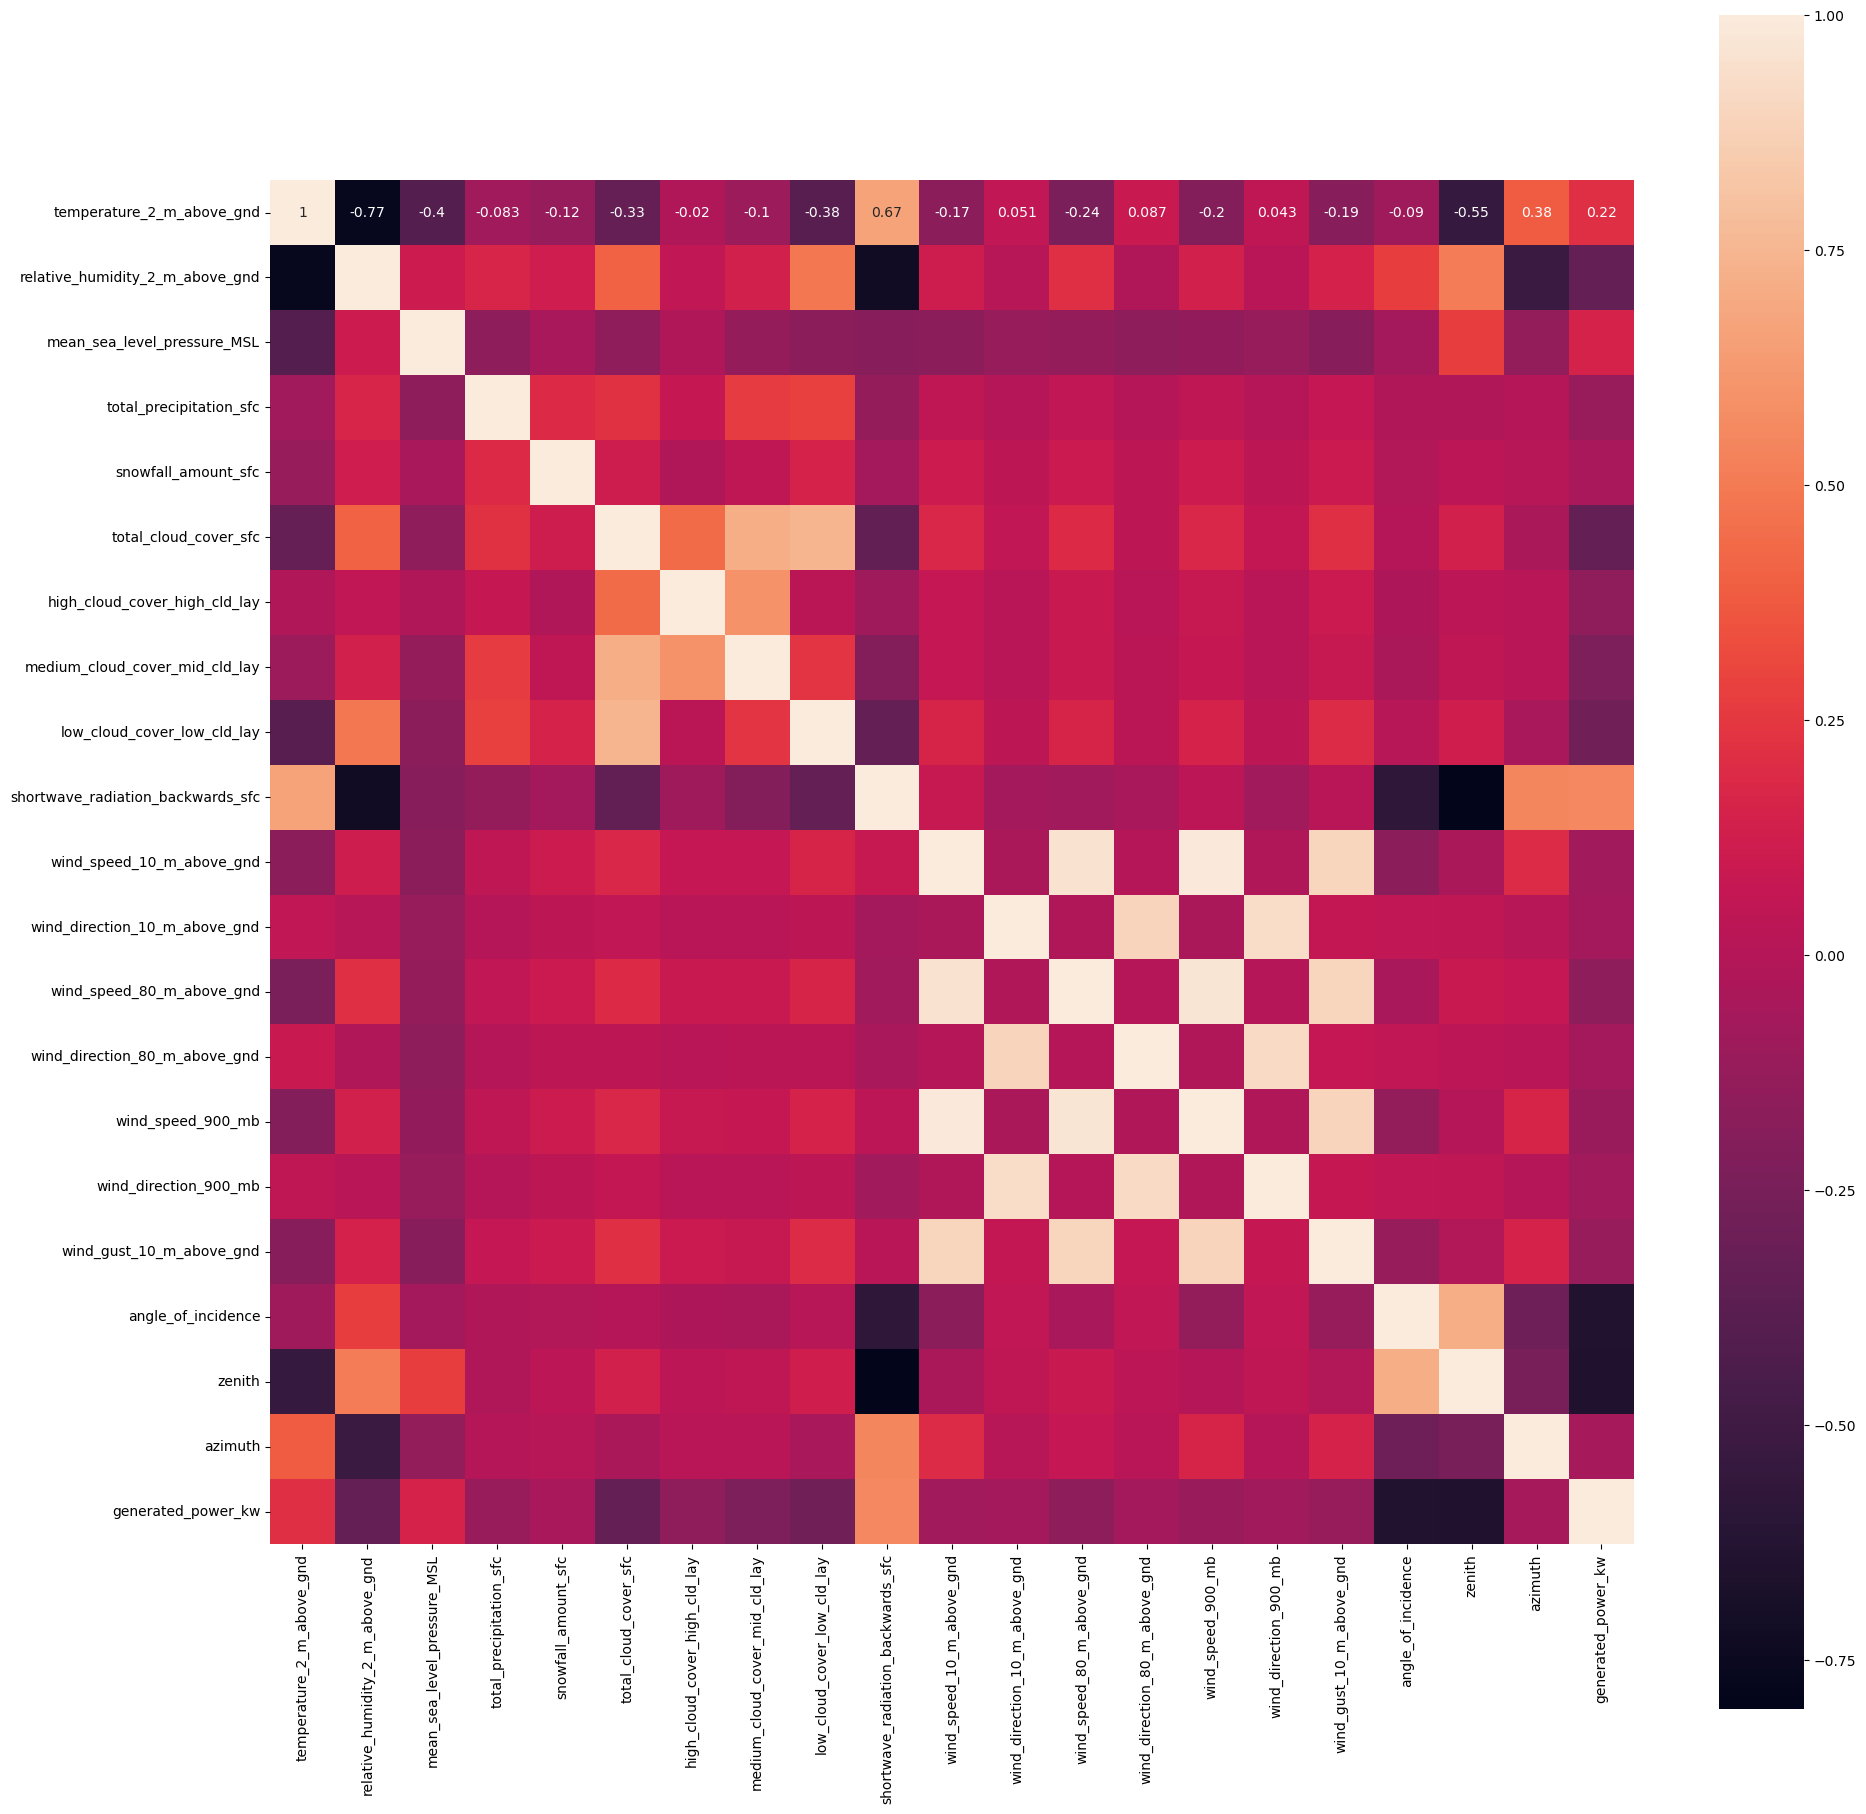

In [14]:
corr = dts.corr()
plt.figure(figsize=(22,22))
sns.heatmap(corr, annot=True, square=True);

In [15]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.001)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_coeff = pd.DataFrame({'Feature Importance':lasso.coef_}, index=dts.columns[:-1])
lasso_coeff.sort_values('Feature Importance', ascending=False)

,Feature Importance
shortwave_radiation_backwards_sfc,0.379804
mean_sea_level_pressure_MSL,0.117743
wind_speed_80_m_above_gnd,0.072826
wind_speed_10_m_above_gnd,0.021176
snowfall_amount_sfc,0.015186
wind_direction_80_m_above_gnd,0.014985
wind_direction_10_m_above_gnd,0.011349
wind_direction_900_mb,-0.000000
total_precipitation_sfc,-0.004486
wind_gust_10_m_above_gnd,-0.034553


<h3>OBSERVATIONS</h3>
     <ul>-> High Correlation between Zenith and Agnle of Incidence of 0.71</ul>
     <ul>-> Shortwave radiation backwards and Generate Power KW has corr of 0.56</ul>
     <ul>-> Relative Humidity and Zenith are +ve corr (0.51)</ul>
     <ul>-> Relative Humidity and Low Cloud Cover are + ve correlated (0.49)</ul>
     <ul>-> Angle of Incidence and Zenith are -vely correlated with Genarted Power (-0.65)</ul>
     <ul>-> -ve corr between Zenith and temperature of -0.55</ul>
     <ul>-> High negative corr exists btw Shortwave radiation backwards and Zenith (-.8)</ul>
     <ul>-> Shortwave radiation backwards and Relative humidity are -vely correlated (-.72)</ul>
     <ul>-> Relative humidity and Temperature are -vely correlated (-.77)</ul>

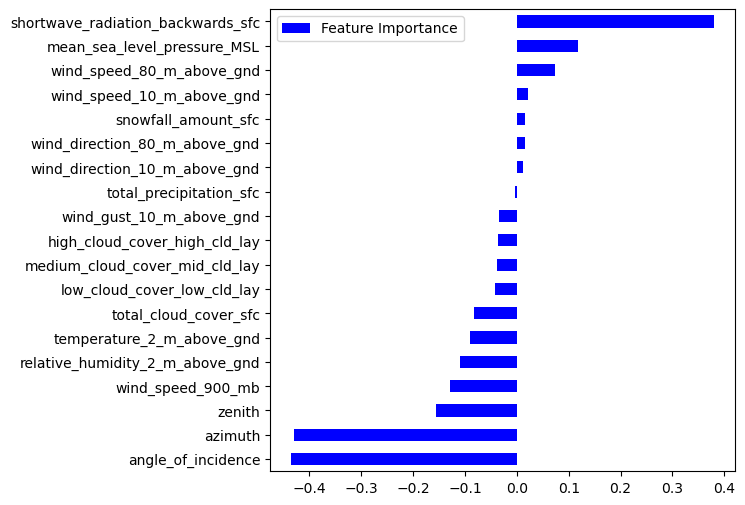

In [16]:
g = lasso_coeff[lasso_coeff['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(6,6), cmap='winter')